<a href="https://colab.research.google.com/github/srikarraju/eGrocery_Demand_Prediction/blob/main/Actor_Critic_LSTM_eGrocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import random
import pandas as pd
from tensorboardX import SummaryWriter

In [ ]:
class EGroceryEnv():

	def __init__(self, df=pd.DataFrame({0:[0]}), products_count=10, features=['a'], shelf_life=[1], wastage_cost=[1], shortage_cost=[1]):
		super(EGroceryEnv, self).__init__()

		self.df = df
		self.products_count = products_count
		self.shelf_life = shelf_life
		self.features = features
		self.wastage_cost = wastage_cost
		self.shortage_cost = shortage_cost
		self.current_step = 0
		self.wastage_track = list([])
		self.shortage_track = list([])
		self.reward_track = list([])

		#variables to track shartage and wastage
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		#Define Stock
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])
		print(features)


	def _next_observation(self):

		obs  = self.df.loc[self.current_step,self.features]

		st_temp = list([])
		for i in range(len(self.stock)):
			for j in range(1,min(int(self.stock[i][0])+1,5)):
				st_temp.append(self.stock[i][j])
			if(self.stock[i][0]==5):
				st_temp.append(self.stock[i][4])
			elif(self.stock[i][0]<5):
				for j in range(int(self.stock[i][0])+1,6):
					st_temp.append(0)
			else:
				st_temp.append(np.sum(self.stock[i][5:int(self.stock[i][0])+1]))
		obs = list(obs) + list(st_temp) + list(self.shelf_life)
		return obs

	def _take_action(self, action):
		#Add products to the current stocks
		for i in range(self.products_count):
			if(len(self.stock[i])<self.shelf_life[i]):
				for j in range(len(self.stock[i]),int(self.shelf_life[i])):
					self.stock[i].append(0)
			self.stock[i].append(action[i])
			self.stock[i][0]=self.shelf_life[i]



		#Fullfill demand
		prods = ['prod'+str(i) for i in [8,11,15,17,94,95,96,110,112,128]]
		demand = self.df.loc[self.current_step+1,prods]
		for i in range(self.products_count):
			for j in range(1,int(self.stock[i][0])+1):
				if(self.stock[i][j]>=demand[i]):
					self.stock[i][j] = self.stock[i][j] - demand[i]
					demand[i] = 0
					break
				else:
					demand[i] = demand[i] - self.stock[i][j]
					self.stock[i][j] = 0
			if(demand[i]>0):
				self.shortage[i]=demand[i]

		#Update shelf life and find out wastage
		for i in range(self.products_count):
			self.stock[i][0] = self.stock[i][0] -1
			if(self.stock[i][1]>0):
				self.wastage[i] = self.stock[i][1]
			for j in range(1,int(self.stock[i][0])+1):
				self.stock[i][j] = self.stock[i][j+1]
			self.stock[i].pop()


	def step(self, action):
	        # update stock, fullfill demand and calculate shortage and wastage
		quantity = [6, 10, 15, 4, 6, 2, 7, 50, 2, 30]
		action1 = [0]*self.products_count
		for i in range(len(action)):
			action1[i] = action[i]*quantity[i]
		self._take_action(action1)
		self.action = action

		#increment step
		self.current_step += 1


		reward = -1*(np.matmul(self.wastage_cost,self.wastage.transpose())+np.matmul(self.shortage_cost,self.shortage.transpose()))
		self.reward = reward
		done = (self.current_step < 0) or (self.current_step > self.df.shape[0]-2)

		obs = self._next_observation()

		self.wastage_track.append(np.sum(self.wastage))
		self.shortage_track.append(np.sum(self.shortage))
		self.reward_track.append(np.abs(self.reward))


		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		return obs, np.sum(self.reward), done, {}

	def reset(self):
		# Reset the state of the environment to an initial state
		self.current_step = 0
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])

		#print(len(self.features),products_count)
		#print(self.features)
		return [0]*len(self.features) + [0]*6*self.products_count

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std, lr, betas):
        super(ActorCritic, self).__init__()
	#actor
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, action_dim),
		nn.ReLU()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1)
                )
        #self.device = device
        self.action_var = torch.full((action_dim,), action_std*action_std)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, betas=betas)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr, betas=betas)
        self.MseLoss = nn.MSELoss()

    def forward(self,state):
        action_mean = self.actor(state)
        #print(action_var)
        action_var = self.action_var.expand_as(action_mean)
        #print(action_var)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, torch.squeeze(state_value), dist_entropy

    def act(self, state):
        state = torch.Tensor(state)
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var)

        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        # memory.states.append(state)
        # memory.actions.append(action)
        # memory.logprobs.append(action_logprob)

        return action.detach()

    def evaluate(self, state, action):
        action_mean = self.actor(state)

        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self,trajectory):
      for sample in trajectory:
        state,action,next_state,reward,done = sample[0],sample[1],sample[2],sample[3],sample[4]
        state = torch.Tensor(state)
        next_state = torch.Tensor(next_state)
        #print(self.critic(state).item())
        #print(self.critic(next_state).item())
        #print(reward)
        td_error = reward + 0.99*self.critic(next_state).item() - self.critic(state).item()
        #print(td_error)

        loss1 = self.MseLoss(reward + 0.99*self.critic(next_state), self.critic(state))
        loss1 = loss1.type(torch.FloatTensor)

        self.critic_optimizer.zero_grad()
        loss1.mean().backward()
        self.critic_optimizer.step()


        action_logprobs ,_ ,_ = self.evaluate(state,action)
        loss2 = td_error*action_logprobs
        loss2 = loss2.type(torch.FloatTensor)

        self.actor_optimizer.zero_grad()
        loss2.mean().backward()
        self.actor_optimizer.step()

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_trainx.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_testx.csv')

#products_count = 10
#products_count = 1
products_count = 4

# avg_f7 = ['prod'+str(i)+'avg7' for i in [8,11,15,17,94,95,96,110,112,128]]
# avg_f15 = ['prod'+str(i)+'avg15' for i in [8,11,15,17,94,95,96,110,112,128]]
# avg_f30 = ['prod'+str(i)+'avg30' for i in [8,11,15,17,94,95,96,110,112,128]]


avg_f7 = ['prod'+str(i)+'avg7' for i in [8,11,15,17]]
avg_f15 = ['prod'+str(i)+'avg15' for i in [8,11,15,17]]
avg_f30 = ['prod'+str(i)+'avg30' for i in [8,11,15,17]]

# avg_f7 = ['prod'+str(i)+'avg7' for i in [8]]
# avg_f15 = ['prod'+str(i)+'avg15' for i in [8]]
# avg_f30 = ['prod'+str(i)+'avg30' for i in [8]]

features = ['month', 'monthday', 'weekday'] + avg_f7 + avg_f15 + avg_f30

print(features)

# shelf_life = np.array([4, 3, 5, 10, 7, 2, 1, 3, 8, 6], dtype=np.float32)
shelf_life = np.array([4, 3, 5, 10], dtype=np.float32)
# shelf_life = np.array([4], dtype=np.float32)

wastage_cost = np.array([1]*products_count, dtype=np.float16)
shortage_cost = np.array([1]*products_count, dtype=np.float16)

action_std = 0.2
eps_clip = 0.2
gamma = 0.99

lr = 0.0001
betas = (0.9, 0.999)
K_epochs = 5

update_timestep = 20
time_step=0
running_reward = 0

state_dim = len(features) + 6*products_count
action_dim = products_count

env = EGroceryEnv(df_train, products_count, features, shelf_life, wastage_cost, shortage_cost)

ac = ActorCritic(state_dim, action_dim, action_std,lr ,betas)

writer = SummaryWriter()

Total_reward = []


['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30']
['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30']


In [ ]:
#print(len(features),products_count,state_dim)
for epoch in range(0,10000):
  #print("Environment Initilaized")
  state = env.reset()
  #print(len(state))
  trajectory = []
  total_reward = 0
  for step in range(0,730):
    #print(state)
    #print("state:",state)
    state = np.asarray(state,dtype=float)
    action = ac.act(state)
    next_state,reward,done,_ = env.step(action)
    #print(reward)
    total_reward += reward
    trajectory.append((state,action,next_state,reward,done))
    state = next_state
    if done==1:
      break
    if step % update_timestep==0:
      ac.update(trajectory)
      trajectory = []
  print("Epoch:",epoch,total_reward)

Epoch: 0 -38971.0
Epoch: 1 -45595.0
Epoch: 2 -45855.0
Epoch: 3 -45789.0
Epoch: 4 -45855.0


KeyboardInterrupt: ignored

In [ ]:
env2 = EGroceryEnv(df_test, products_count, features, shelf_life, wastage_cost, shortage_cost)
state = env2.reset()
for step in range(0,30):
  #print("state:",state)
  state = np.asarray(state,dtype=float)
  action = ac.act(state)
  print(action)
  next_state,reward,done,_ = env2.step(action)
  print(reward)
  state = next_state
print(env2.reward_track)

['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30']
tensor([-0.0929,  0.2997,  0.2224, -0.0275])
-100.0
tensor([-0.2205, -0.0048, -0.0062, -0.0723])
-88.0
tensor([-0.1712,  0.0304,  0.0430, -0.4137])
-102.0
tensor([-0.1281,  0.1017, -0.4770,  0.0581])
-75.0
tensor([-0.1441, -0.3436, -0.2075, -0.0897])
-90.0
tensor([ 0.3813,  0.0340,  0.2729, -0.0158])
-133.0
tensor([-0.0874, -0.2199,  0.2122,  0.1482])
-96.0
tensor([-0.0824,  0.2735, -0.1354,  0.0586])
-109.0
tensor([-0.3401,  0.0551,  0.0183,  0.0613])
-134.0
tensor([-0.3479,  0.3867, -0.1819,  0.2928])
-52.0
tensor([-0.2064,  0.1083, -0.0263,  0.1240])
-60.0
tensor([-0.0569, -0.0800, -0.2358, -0.1010])
-95.0
tensor([-0.1455,  0.0637,  0.1313, -0.4064])
-116.0
tensor([ 0.1891, -0.1961,  0.0300, -0.1582])
-88.0
tensor([ 0.4544,  0.0338,  0.4091, -0.0893])
-46.0
tensor([ 0.1060, -0.106

In [ ]:
print(sum(env2.reward_track)/len(env2.reward_track))
print(env2.wastage_track)
print(env2.shortage_track)

100.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[100, 88, 102, 75, 90, 133, 96, 109, 134, 52, 60, 95, 116, 88, 46, 131, 134, 101, 103, 105, 102, 67, 79, 74, 62, 86, 135, 153, 142, 142]


31
31
31


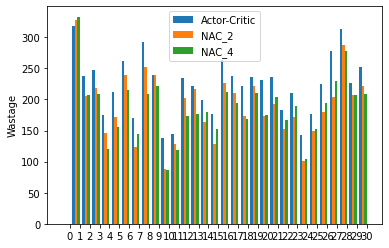

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 31
DQN_wastage = (0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345)
Actor_critic = (0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252)
PPO = (0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283)
NAC4 = [0, 333, 207, 208, 121, 155, 215, 145, 208, 221, 86, 119, 174, 176, 179, 153, 212, 195, 168, 210, 175, 204, 167, 189, 104, 152, 195, 230, 278, 207, 209]
NAC2 = [0, 328, 206, 218, 146, 172, 239, 123, 252, 239, 88, 129, 203, 217, 163, 129, 226, 211, 173, 221, 174, 193, 152, 171, 101, 149, 179, 204, 287, 207, 222]
print(len(DQN_wastage))
print(len(Actor_critic))
print(len(PPO))

ind = np.arange(N)
ind = 2*ind
width = 0.5
plt.bar( ind,Actor_critic, width, label='Actor-Critic')
plt.bar(ind + width, NAC2 , width,label='NAC_2')
plt.bar(ind + width + width, NAC4, width,label='NAC_4')

plt.ylabel('Wastage')
#plt.title('Scores by group and gender')

plt.xticks(ind + 5*width / 2, np.arange(N))
plt.legend(loc='best')
plt.savefig('Shortage.png')